# 1. Importações de bibliotecas e carregamento de dados

In [1]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 29.3 MB/s 


In [2]:
# Importando bibliotecas necessárias
import json
import numpy as np
import pandas as pd
import math
import sys
import os
import seaborn as sns
import tensorflow as tf
from numpy import zeros, array, asarray
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot
from matplotlib.pyplot import figure
import keras_tuner as kt
from keras import metrics
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout, Activation
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Parametros modificados com frequência
debug = True
col_switch = ('summary', 'description')
xcol = col_switch[1]

# Esses são importantes
tubelis = True
rstate = 7
docs_length = 'mean'
z_score_threshold = 1
z_score_times = 5
embedding_size = 64
emb_model_learning_rate = 0.005
wind = 5
mcount = 25
norm_vectors = True
lstm = True
dense_layers = False
dropout = True
dropout_default_value = 0.7
optmizer = 'rms' #adam or rms
#mmentum = 0.09
#psilon = 1e-07
#ctered = False
num_epochs = 20
batch_size = 64
validation_size = 0.25

In [5]:
# Abrindo dados como ndarray
if tubelis:
  data = []
  path = './drive/MyDrive/ColabNotebooks/data/'
  filelist = os.listdir(path)
  filelist.sort()
  # filelist = ['EVL_lab_clean.json']
  repo_num = len(filelist)
  print("Numero de repositorios: {}".format(repo_num))
  for filename in filelist:
    with open(path + filename, 'r') as file:
      repo = json.load(file)
      data += repo
  ndata = pd.DataFrame(data).values
  pd_data = pd.DataFrame(data)
  if debug:
    print(ndata)
    print(ndata.shape)
  
  # Removendo linhas com description null
  bool_series = pd.notnull(pd_data['description']) 
  pd_data = pd_data[bool_series]

  nan_value = float("NaN")

  pd_data.replace("", nan_value, inplace=True)
  pd_data.replace(" ", nan_value, inplace=True)
  pd_data.replace("nan", nan_value, inplace=True)

  pd_data.dropna(subset = ["description"], inplace=True)

  # Removendo linhas com summary null
  bool_series = pd.notnull(pd_data['summary']) 
  pd_data = pd_data[bool_series]

  # Removendo linhas com timespent null
  bool_series = pd.notnull(pd_data['timespent']) 
  pd_data = pd_data[bool_series]

Numero de repositorios: 70
[['14161' 'ABU'
  list(['contrib-graphic remove body attribute from example.json'])
  list(["i know it's a core model attribute but it's not actually used in this component so it's a little misleading to list it in example.json"])
  '1800' 96.0]
 ['14436' 'ABU' list(['remove readme.pdf'])
  list(["this pdf is hugely and no longer req'd"]) '120' 97.0]
 ['14201' 'ABU' list(['unused color variables'])
  list(['remove from colors.less file or use in theme']) '1800' 97.0]
 ...
 ['10102' 'ZONG' list(["andi's work in"]) nan '3589200' nan]
 ['10010' 'ZONG'
  list(['create diagrams showing the zong modules and their dependencies'])
  nan '9600' nan]
 ['10009' 'ZONG' list(['write guide how to build zong']) nan '11400' nan]]
(97274, 6)


In [6]:
if not tubelis:  
  path = './drive/MyDrive/ColabNotebooks/tasks/'
  filelist = os.listdir(path)

  pd_data = pd.read_csv(path + filelist[0])
  for i in range(1, len(filelist)):
    pd_data2 = pd.read_csv(path + filelist[i])
    pd_data = pd.concat([pd_data, pd_data2], ignore_index=True)

  # Removendo linhas com Resolvido null
  bool_series = pd.notnull(pd_data['Resolvido']) 
  pd_data = pd_data[bool_series]

  # Removendo linhas com Criado null
  bool_series = pd.notnull(pd_data['Criado']) 
  pd_data = pd_data[bool_series]


# 2. Limpeza dos dados

In [7]:
def print_all(df):
  with pd.option_context('display.max_rows', None):  # more options can be specified also
    print(df)

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def id_removes(text):
  return re.sub('\[(\w|\W)*\]', '', text)

def link_removes(text):
  return re.sub('(http:|https:)\/\/(\w+|\W+\.\w+\W+(\.\w+\W+)*)(\/\w+|\W+|\w+)*', '', text)

def remove_stop_words(text):
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(text)
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  return ' '.join(filtered_sentence)

def stemming(text):
  ps = PorterStemmer()
  words = word_tokenize(text)
  stemmed_sentence = [ps.stem(w) for w in words]
  return ' '.join(stemmed_sentence)

def lemmatize(text):
  words = word_tokenize(text)
  le = WordNetLemmatizer()
  lemmatized_sentence = [le.lemmatize(w) for w in words]
  return ' '.join(lemmatized_sentence)

def num_remove(text):
  word_tokens = word_tokenize(text)
  non_num_seq = []
  for word in word_tokens:
    if re.match('\d+', word):
      non_num_seq.append(re.sub('\d+', '', word))
    else:
      non_num_seq.append(word)
  return ' '.join(non_num_seq)

def len_cut(text):
  word_tokens = word_tokenize(text)
  cutted = [w for w in word_tokens if not len(w) == 1]
  return ' '.join(cutted)

def list_to_str(text_list):
  sentence_agg = ''
  for item in text_list:
    sentence_agg += item
    sentence_agg += ' '
  return sentence_agg.rstrip()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [9]:
def clean_str(my_str):
  clean_list = ["'", "(", ")"]
  space_list = [".", "-", "/", "#", ":", "<", ">", "_", "[", "]", "+", "{", "}", "!", "@", "$", "%", "*", "=", "…", "?", "`", ",", "\r", "\n", "\d", '"', "~", "^", "PR", "|", "&"]
  for ccrt in clean_list:
    if(ccrt in my_str):
      my_str = my_str.replace(ccrt,"")  
  for scrt in space_list:
    if(scrt in my_str):
      my_str = my_str.replace(scrt," ")
  return my_str.lower()

In [10]:
from datetime import datetime
def time_calc(date1, date2):
  pattern = "%Y-%m-%d %I:%M %p"
  d1 = datetime.strptime(date1, pattern)
  d2 = datetime.strptime(date2, pattern)

  delta = d2 - d1
  return delta.total_seconds() / 60

In [11]:
if tubelis:
  resumo = pd_data['summary'].apply(list_to_str) 
  resumo = resumo.apply(id_removes)  
else:
  resumo = pd_data['Resumo'].apply(id_removes)
# resumo = resumo.apply(clean_str)
# resumo = resumo.apply(remove_stop_words)
# resumo = resumo.apply(lemmatize)
# #resumo = resumo.apply(stemming)
# resumo = resumo.apply(num_remove)
# resumo = resumo.apply(len_cut)
resumo.replace('', np.nan, inplace=True)
resumo.astype(str)

if tubelis:
  tempo = pd_data['timespent']
else:
  tempo = pd_data.apply(lambda x: time_calc(x.Criado, x.Resolvido), axis=1)
tempo.replace('', np.nan, inplace=True)

if tubelis:
  descricao = pd_data['description'].apply(list_to_str)  
else:
  descricao = pd_data['Descrição'].astype(str)
# descricao = descricao.apply(id_removes)
# descricao = descricao.apply(link_removes)
# descricao = descricao.apply(clean_str)
# descricao = descricao.apply(remove_stop_words)
# descricao = descricao.apply(lemmatize)
#descricao = descricao.apply(stemming)
# descricao = descricao.apply(num_remove)
# descricao = descricao.apply(len_cut)
descricao.replace('', np.nan, inplace=True)

In [12]:
resumo

0        contrib-graphic remove body attribute from exa...
1                                        remove readme.pdf
2                                   unused color variables
3                         review outstanding pull requests
4                    remove istrackable from adaptmodel.js
                               ...                        
97249                                             clean up
97250    java se implementation for xmlreader and xmlwr...
97251                                       clean up utils
97252                  java se dependencies in own project
97253                               update java formatting
Name: summary, Length: 72348, dtype: object

In [13]:
pd_data = pd.DataFrame()
pd_data['summary'] = resumo
pd_data['description'] = descricao
pd_data['timespent'] = tempo

In [14]:
# Convertendo o timespent para float
pd_data['timespent'] = pd_data.timespent.astype(float)

# Removendo linhas com description null
bool_series = pd.notnull(pd_data['description']) 
pd_data = pd_data[bool_series]

nan_value = float("NaN")

pd_data.replace("", nan_value, inplace=True)
pd_data.replace(" ", nan_value, inplace=True)
pd_data.replace("nan", nan_value, inplace=True)

pd_data.dropna(subset = ["description"], inplace=True)

# Removendo linhas com summary null
bool_series = pd.notnull(pd_data['summary']) 
pd_data = pd_data[bool_series]

# Removendo linhas com timespent null
bool_series = pd.notnull(pd_data['timespent']) 
pd_data = pd_data[bool_series]

# 3. Remoção inicial de outliers

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


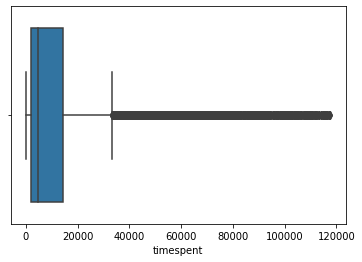

In [15]:
# Criando função zscore e aplicando uma vez
def my_zscore(x):
  return ((x - x.mean())/x.std())

cara =  my_zscore(pd_data['timespent'])
df_sem_outlier_z = pd.DataFrame(
    pd_data[(abs(cara) < z_score_threshold)])
sns.boxplot(df_sem_outlier_z['timespent'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


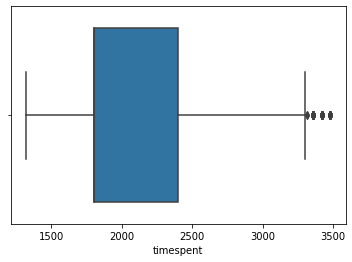

In [16]:
# Aplicando o z score mais vezes para remover mais os outliers
for i in range(z_score_times):
  # z_score_threshold = 1
  cara =  my_zscore(df_sem_outlier_z['timespent'])
  df_sem_outlier_z = pd.DataFrame(
      df_sem_outlier_z[(abs(cara) < z_score_threshold)])

sns.boxplot(df_sem_outlier_z['timespent'])

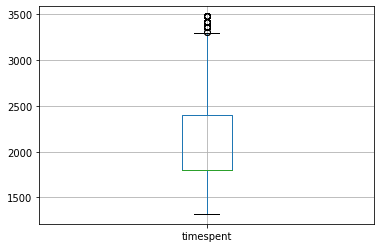

In [17]:
df_sem_outlier_z.boxplot('timespent')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb35e127b10>]],
      dtype=object)

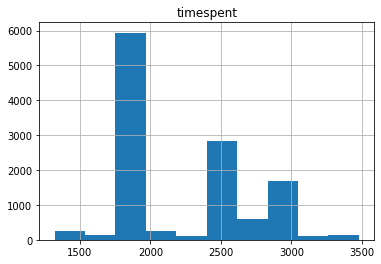

In [18]:
df_sem_outlier_z.hist('timespent')

In [19]:
df_sem_outlier_z

,summary,description,timespent
0,contrib-graphic remove body attribute from exa...,i know it's a core model attribute but it's no...,1800.0
2,unused color variables,remove from colors.less file or use in theme,1800.0
7,grunt task runner dev task does not copy json ...,the watch task that runs if you do grunt dev w...,1800.0
13,narrative component,the headings for each component item are stack...,1800.0
17,play and ended completion events don't work wh...,looks like mediaelement.js doesn't broadcast e...,1800.0
...,...,...,...
97236,log time of previous work,import working hours per year and per user and...,2400.0
97239,build server and continuous integration based ...,setup a bamboo server for xenoage utils and cr...,1800.0
97240,source code management based on github,install stash and move the zong and xenoage ut...,1800.0
97245,javafx utils in new project,move some of the generally useful javafx utils...,2700.0


In [20]:
data = df_sem_outlier_z

# 4. Análise exploratória dos dados

In [21]:
data

,summary,description,timespent
0,contrib-graphic remove body attribute from exa...,i know it's a core model attribute but it's no...,1800.0
2,unused color variables,remove from colors.less file or use in theme,1800.0
7,grunt task runner dev task does not copy json ...,the watch task that runs if you do grunt dev w...,1800.0
13,narrative component,the headings for each component item are stack...,1800.0
17,play and ended completion events don't work wh...,looks like mediaelement.js doesn't broadcast e...,1800.0
...,...,...,...
97236,log time of previous work,import working hours per year and per user and...,2400.0
97239,build server and continuous integration based ...,setup a bamboo server for xenoage utils and cr...,1800.0
97240,source code management based on github,install stash and move the zong and xenoage ut...,1800.0
97245,javafx utils in new project,move some of the generally useful javafx utils...,2700.0


[1320. 1380. 1440. 1488. 1500. 1560. 1620. 1680. 1692. 1740. 1800. 1815.
 1830. 1860. 1890. 1920. 1980. 2040. 2052. 2088. 2100. 2160. 2220. 2268.
 2280. 2340. 2400. 2412. 2448. 2460. 2520. 2580. 2628. 2640. 2700. 2715.
 2760. 2820. 2880. 2940. 3000. 3012. 3048. 3060. 3120. 3168. 3180. 3240.
 3276. 3300. 3312. 3360. 3420. 3480.]
54


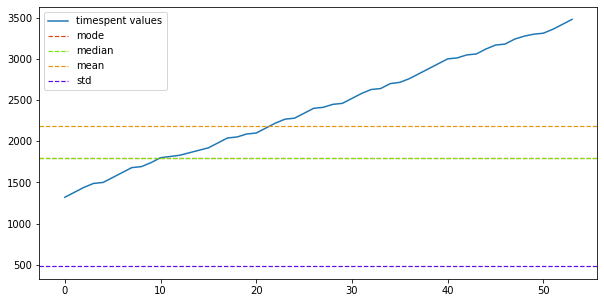

In [22]:
# Verificando quais os tempos estimados existentes
uniq = data['timespent'].unique()
uniq.sort(axis=0)
print(uniq)
print(len(uniq))

mode = data['timespent'].mode()[0]
median = data['timespent'].median()
mean = data['timespent'].describe()['mean']
std = data['timespent'].describe()['std']

pyplot.figure(figsize=(10,5))
pyplot.plot(uniq, label="timespent values")
pyplot.axhline(y=mode, label="mode", color="#e6440e", linestyle="dashed", linewidth=1.2)
pyplot.axhline(y=median, label="median", color="#7ae60e", linestyle="dashed", linewidth=1.2)
pyplot.axhline(y=mean, label="mean", color="#e6960e", linestyle="dashed", linewidth=1.2)
pyplot.axhline(y=std, label="std", color="#5d0ee6", linestyle="dashed", linewidth=1.2)
pyplot.legend()
pyplot.show()

In [23]:
data['timespent'].describe()

count    12056.000000
mean      2186.619028
std        480.102688
min       1320.000000
25%       1800.000000
50%       1800.000000
75%       2400.000000
max       3480.000000
Name: timespent, dtype: float64

In [24]:
# dvc = data['timespent'].value_counts()
# dvcs = dvc.sort_index()
# dvcs.index.to_numpy().astype(str)

# pyplot.figure(figsize=(10,10))
# pyplot.bar(dvcs.index.to_numpy().astype(str), dvcs.values)
# pyplot.show()

In [25]:
# uniq = data['timespent'].unique()
# uniq.sort(axis=0)
# print(uniq)
# print(len(uniq))

# mode = data['timespent'].mode()[0]
# median = data['timespent'].median()
# mean = data['timespent'].describe()['mean']
# std = data['timespent'].describe()['std']

# pyplot.figure(figsize=(10,5))
# pyplot.plot(uniq, label="timespent values")
# pyplot.axhline(y=mode, label="mode", color="#e6440e", linestyle="dashed", linewidth=1.2)
# pyplot.axhline(y=median, label="median", color="#7ae60e", linestyle="dashed", linewidth=1.2)
# pyplot.axhline(y=mean, label="mean", color="#e6960e", linestyle="dashed", linewidth=1.2)
# pyplot.axhline(y=std, label="std", color="#5d0ee6", linestyle="dashed", linewidth=1.2)
# pyplot.legend()
# pyplot.show()

# Criação do modelo

In [26]:
# Obtendo todas as palavras das description para serem treinadas
all_text = []
for des_str in data['description'].values:
  des_str = clean_str(des_str)
  all_text.append(des_str.split())

for sum_str in data['summary'].values:
  sum_str = clean_str(sum_str)
  all_text.append(sum_str.split())

if debug:
  print(len(all_text))
  print(all_text)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [27]:
# Definindo o modelo de word embeddings
emb_model = Word2Vec(all_text,
                     seed=rstate, 
                     sg=1,
                     hs=0, 
                     iter=num_epochs, 
                     window=wind, 
                     min_count=mcount, 
                     size=embedding_size, 
                     alpha=emb_model_learning_rate)
if norm_vectors:
  emb_model.init_sims(replace=True)
# Resumo do modelo
if debug:
  print(emb_model)
words = list(emb_model.wv.vocab)
if debug:
  print(words)

vocab_size = len(words) + 1
if debug:
  print(vocab_size)

Word2Vec(vocab=2636, size=64, alpha=0.005)
['i', 'know', 'its', 'a', 'core', 'model', 'attribute', 'but', 'not', 'actually', 'used', 'in', 'this', 'component', 'so', 'little', 'to', 'list', 'it', 'example', 'json', 'remove', 'from', 'less', 'file', 'or', 'use', 'theme', 'the', 'watch', 'task', 'that', 'runs', 'if', 'you', 'do', 'dev', 'will', 'for', 'changes', 'config', 'then', 'copy', 'into', 'build', 'when', 'is', 'changed', 'saved', 'replicate', 'run', 'make', 'change', 'and', 'save', 'observe', 'command', 'line', 'says', 'src', 'course', 'tasks', 'are', 'go', 'has', 'been', 'updated', 'each', 'item', 'on', 'top', 'of', 'other', 'see', 'buttons', 'work', 'button', 'doesnt', 'also', 'occurs', 'same', 'behaviour', 'nexus', 'android', 'looks', 'like', 'js', 'events', 'source', 'might', 'well', 'be', 'needs', 'testing', 'assume', 'we', 'could', 'probably', 'our', 'way', 'around', 'event', 'by', 'user', 'clicks', 'video', 'completion', 'easy', 'though', 'support', 'drop', 'slider', 'icon

In [28]:
# Brincando com o modelo
print(emb_model.wv.similarity('python', 'code'))
emb_model.wv.most_similar(positive=['python'], topn=10)


0.47701505


[('pandas', 0.8773329257965088),
 ('dataflow', 0.8588026762008667),
 ('runner', 0.8551086783409119),
 ('flight', 0.8469647169113159),
 ('portable', 0.8442491292953491),
 ('gandiva', 0.8435598611831665),
 ('rust', 0.8391199707984924),
 ('compiled', 0.8364507555961609),
 ('conversion', 0.8360700011253357),
 ('pyarrow', 0.8304824829101562)]

In [29]:
# Comparando vetores de palavras
# pyplot.figure(figsize=(10,3))
# w1 = 'size'
# w2 = 'file'
# w1v = emb_model.wv.get_vector(w1)
# w2v = emb_model.wv.get_vector(w2)
# pyplot.plot(w1v, label=w1)
# pyplot.plot(w2v, label=w2)
# pyplot.legend()
# pyplot.show()

In [30]:
# Obtendo a lista de docs concatenando summary + description
docs = []
for i in range(len(data)):
  summ = data['summary'].values[i]
  desc = data['description'].values[i]
  # sentence_agg = ""
  # for sum_item in summ:
  #   sum_item = clean_str(sum_item)
  #   sentence_agg += sum_item
  #   sentence_agg += " "
  # for desc_item in desc:
  #   desc_item = clean_str(desc_item)
  #   sentence_agg += desc_item
  #   sentence_agg += " "
  # sentence_agg = sentence_agg.rstrip()
  docs.append(summ + desc)
for i in range(10):
  print(docs[i])
print(len(docs))

contrib-graphic remove body attribute from example.jsoni know it's a core model attribute but it's not actually used in this component so it's a little misleading to list it in example.json
unused color variablesremove from colors.less file or use in theme
grunt task runner dev task does not copy json changes to the buildthe watch task that runs if you do grunt dev will watch for changes to config.json but then copy config.json into the build when this file is changed saved to replicate run grunt dev make a change to and save the file observe that the command line says file src course config.json changed and that the and copy:coursejson tasks are run go to observe that config.json has not been updated
narrative componentthe headings for each component item are stacked on top of each other see buttons and work button doesn't this also occurs in same behaviour on nexus android
play and ended completion events don't work when the source is vimeolooks like mediaelement.js doesn't broadcast

In [31]:
docs_len = []
for doc in docs:
  docs_len.append(len(doc.split()))
print(docs_len[0:10])

[30, 10, 82, 29, 60, 13, 35, 44, 18, 19]


In [32]:
df_sem_outlier_z = data

In [33]:
df_sem_outlier_z['docs_lens'] = docs_len

In [34]:
df_sem_outlier_z

,summary,description,timespent,docs_lens
0,contrib-graphic remove body attribute from exa...,i know it's a core model attribute but it's no...,1800.0,30
2,unused color variables,remove from colors.less file or use in theme,1800.0,10
7,grunt task runner dev task does not copy json ...,the watch task that runs if you do grunt dev w...,1800.0,82
13,narrative component,the headings for each component item are stack...,1800.0,29
17,play and ended completion events don't work wh...,looks like mediaelement.js doesn't broadcast e...,1800.0,60
...,...,...,...,...
97236,log time of previous work,import working hours per year and per user and...,2400.0,26
97239,build server and continuous integration based ...,setup a bamboo server for xenoage utils and cr...,1800.0,53
97240,source code management based on github,install stash and move the zong and xenoage ut...,1800.0,46
97245,javafx utils in new project,move some of the generally useful javafx utils...,2700.0,30


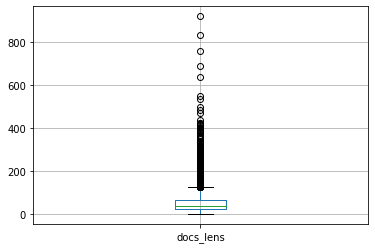

In [35]:
df_sem_outlier_z.boxplot('docs_lens')

In [36]:
# Tamanho máximo dos docs
max_length_des = 0
if docs_length == 'mean':
  max_length_des = int(df_sem_outlier_z['docs_lens'].mean())
  if debug:
    print(max_length_des)
elif docs_length == 'min':
  max_length_des = int(df_sem_outlier_z['docs_lens'].min())
  if debug:
    print(max_length_des)
else:
  for desc in data[xcol].values:
    sentence_size = 0
    for sentence in desc:
      sentence_size += len(sentence.split())
    if sentence_size > max_length_des:
      max_length_des = sentence_size
  if debug:
    print(max_length_des)

52


In [37]:
# Carregando as embeddings pré-treinadas
# embeddings_index = dict()
# f = open(emb_file.get(embedding_size))
# for line in f:
# 	values = line.split()
# 	word = values[0]
# 	coefs = asarray(values[1:], dtype='float32')
# 	embeddings_index[word] = coefs
# f.close()
# print('Loaded %s word vectors.' % len(embeddings_index))

In [38]:
# Quantas palavras não estão na embeddings pré treinadas
# count = 0
# for word in words:
#   if word not in embeddings_index:
#     count += 1
#     #print(word)
# print(count)

In [39]:
for word in words:
  print(word)

i
know
its
a
core
model
attribute
but
not
actually
used
in
this
component
so
little
to
list
it
example
json
remove
from
less
file
or
use
theme
the
watch
task
that
runs
if
you
do
dev
will
for
changes
config
then
copy
into
build
when
is
changed
saved
replicate
run
make
change
and
save
observe
command
line
says
src
course
tasks
are
go
has
been
updated
each
item
on
top
of
other
see
buttons
work
button
doesnt
also
occurs
same
behaviour
nexus
android
looks
like
js
events
source
might
well
be
needs
testing
assume
we
could
probably
our
way
around
event
by
user
clicks
video
completion
easy
though
support
drop
slider
icon
attached
as
requires
choose
images
image
option
description
options
text
question
at
end
links
every
select
whole
side
necessary
reached
contents
review
quality
feedback
goes
push
adapt
github
wiki
left
forward
right
back
works
have
occurred
after
merging
following
pr
arrows
always
present
even
first
arrow
takes
last
loop
wrong
validation
variable
variables
returning
main
menu


In [40]:
# Quantas palavras não estão nas embeddings
count = 0
for word in words:
  w_vec = emb_model.wv.get_vector(word)
  if w_vec is None:
    count += 1
    #print(word)
print(count)

0


In [41]:
# Criando a matriz de embeddings [pré-treinadas]
# words_index = dict()
# embedding_matrix = zeros((vocab_size, embedding_size))
# for i, word in enumerate(words, start=1):
# 	embedding_vector = embeddings_index.get(word)
# 	if embedding_vector is not None:
# 		embedding_matrix[i] = embedding_vector
# 		words_index[word] = i

In [42]:
# Criando a matriz de embeddings
words_index = dict()
embedding_matrix = zeros((vocab_size, embedding_size))
for i, word in enumerate(words, start=1):
	embedding_vector = emb_model.wv.get_vector(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
		words_index[word] = i

In [43]:
doc_encoded = zeros((max_length_des))
print(doc_encoded.shape)

(52,)


In [44]:
len(docs)

12056

In [45]:
# Codificando os documentos
padded_docs = zeros((len(docs), max_length_des))
for i, doc in enumerate(docs):
  doc_word_list = doc.split()
  doc_encoded = zeros((max_length_des))
  for j, word in enumerate(doc_word_list):
    if j < max_length_des:
      w_index = words_index.get(word)
      if w_index is not None:
        doc_encoded[j] = w_index
  padded_docs[i] = doc_encoded
padded_docs     

array([[   0.,   22.,  414., ...,    0.,    0.,    0.],
       [1745.,  570.,    0., ...,    0.,    0.,    0.],
       [   0.,   31., 2158., ...,   17.,   54.,   55.],
       ...,
       [  89.,  268., 1067., ...,    0.,    0.,    0.],
       [   0., 2190.,   12., ...,    0.,    0.,    0.],
       [  45.,  449.,    0., ...,    0.,    0.,    0.]])

In [46]:
print(padded_docs.shape)

(12056, 52)


In [47]:
# Particionando conjunto de teste e treino para avaliação
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(padded_docs, data['timespent'].values, test_size=validation_size, random_state=rstate)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(9042, 52)
(3014, 52)
(9042,)
(3014,)


9042

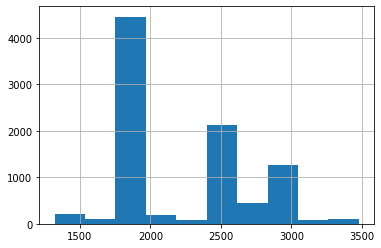

In [48]:
ytp = pd.Series(y_train)
ytp.hist()
len(y_train)

3014

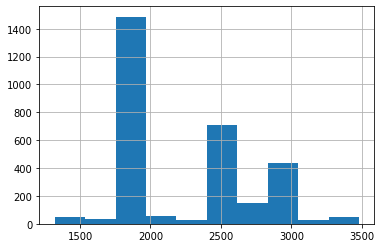

In [49]:
ytt = pd.Series(y_test)
ytt.hist()
len(y_test)

In [50]:
# Definindo o modelo
from tensorflow import keras
# if optmizer == 'adam':
#   opt = keras.optimizers.Adam(optmizer_learning_rate)
# elif optmizç;er == 'rms':
#   opt = keras.optimizers.RMSprop(learning_rate=optmizer_learning_rate, 
#                                  momentum=mmentum,
#                                  epsilon=psilon,
#                                  centered=ctered)
def compile_model(hp):
  model = Sequential()
  e = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], input_length=max_length_des, trainable=False)
  model.add(e)
  hp_de = hp.Boolean('dense_layers')
  # hp_cl = hp.Choice('core_layer', ['lstm', 'flatten'])
  hp_dv = hp.Float('dropout_value', min_value=0.3, max_value=0.999, step=0.01)
            
  # if hp_cl == 'lstm':
  #   with hp.conditional_scope('core_layer', ['lstm']):
  model.add(Bidirectional(LSTM(max_length_des)))
  model.add(Dropout(hp_dv))
  # if hp_cl == 'flatten':
  #   with hp.conditional_scope('core_layer', ['flatten']):
  #     model.add(Flatten())
  #     model.add(Dropout(hp_dv))
  if hp_de:
    with hp.conditional_scope('dense_layers', True):
      model.add(Dense(256, activation='relu'))
      model.add(Dropout(hp_dv))
      model.add(Dense(128, activation='relu'))
      model.add(Dropout(hp_dv))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(hp_dv))
  model.add(Dense(1))
  hp_lr = hp.Float('learning_rate', min_value=0.001, max_value=0.9, step=0.01)
  # hp_mm = hp.Float('momentum', min_value=0, max_value=1, step=0.1)
  hp_ct = hp.Boolean('centered')
  # hp_pi = hp.Choice('epsilon', values=[1e-07, 1e-08, 1e-09, 1e-10])
  opt = keras.optimizers.RMSprop(learning_rate=hp_lr, 
                                #  momentum=hp_mm,
                                #  epsilon=hp_pi,
                                 centered=hp_ct)
  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  # Resumo do modelo
  print(model.input_shape)
  print(model.summary())
  return model

In [51]:
tuner = kt.Hyperband(compile_model,
                     objective='val_mae',
                     max_epochs=5,
                     factor=3,
                     overwrite=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner.search(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=validation_size, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [00h 00m 46s]
val_mae: nan

Best val_mae So Far: 392.0519104003906
Total elapsed time: 00h 05m 12s
INFO:tensorflow:Oracle triggered exit


In [52]:
best_hps.values

{'centered': True,
 'dense_layers': False,
 'dropout_value': 0.8100000000000005,
 'learning_rate': 0.011,
 'tuner/bracket': 1,
 'tuner/epochs': 5,
 'tuner/initial_epoch': 2,
 'tuner/round': 1,
 'tuner/trial_id': '0001'}

# Treinando e avaliando o modelo

(None, 52)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 52, 64)            168768    
                                                                 
 bidirectional (Bidirectiona  (None, 104)              48672     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 104)               0         
                                                                 
 dense (Dense)               (None, 64)                6720      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                             

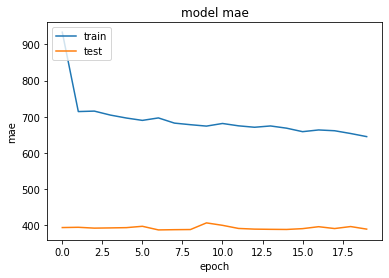

In [53]:
# Treinando com todos os datasets
from keras.backend import clear_session
clear_session()

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=validation_size, verbose=1)

#models.append(model)
pyplot.plot(history.history['mae'])
pyplot.plot(history.history['val_mae'])
pyplot.title('model mae')
pyplot.ylabel('mae')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'test'], loc='upper left')
pyplot.show()

In [54]:
val_mae_epoch = history.history['val_mae']
best_epoch = val_mae_epoch.index(min(val_mae_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 7


In [55]:
# from keras.backend import clear_session
# clear_session()

# model = tuner.hypermodel.build(best_hps)

# # Retrain the model
# history = model.fit(x_train, y_train, epochs=best_epoch, batch_size=batch_size, validation_split=validation_size, verbose=1)

# #models.append(model)
# pyplot.plot(history.history['mae'])
# pyplot.plot(history.history['val_mae'])
# pyplot.title('model mae')
# pyplot.ylabel('mae')
# pyplot.xlabel('epoch')
# pyplot.legend(['train', 'test'], loc='upper left')
# pyplot.show()

In [56]:
# Fazendo e avaliando previsões com o melhor modelo
# model = models[4]
predictions = model.predict(x_test)
print(predictions[0:10])

[[1750.0437]
 [2045.531 ]
 [2009.3715]
 [1648.5612]
 [1821.1011]
 [1931.5913]
 [1927.5116]
 [2056.398 ]
 [1661.7092]
 [1958.051 ]]


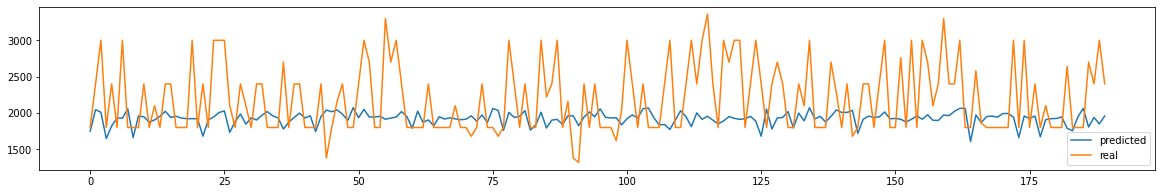

In [57]:
psize = 190
pyplot.figure(figsize=(20,3))
pyplot.plot(predictions[0:psize], label='predicted')
pyplot.plot(y_test[0:psize], label='real')
pyplot.legend()
pyplot.show()

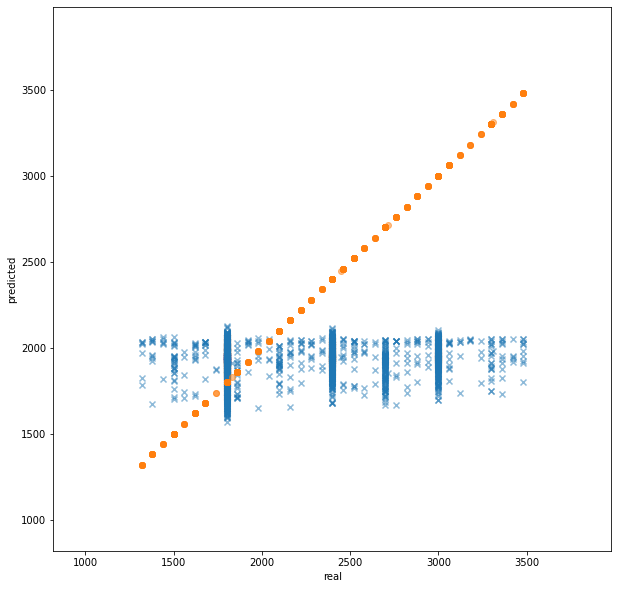

In [58]:
def plot_results(y_test, predictions):
  x_lim = max(y_test.max(), predictions.max()) + 500
  y_lim = min(y_test.min(), predictions.min()) - 500
  pyplot.figure(figsize=(10,10))
  pyplot.scatter(y_test, predictions, marker='x', alpha=0.5)
  pyplot.scatter(y_test, y_test, marker='o', alpha=0.5)
  pyplot.xlim(y_lim, x_lim)
  pyplot.ylim(y_lim, x_lim)
  pyplot.xlabel("real")
  pyplot.ylabel("predicted")
  pyplot.show()
plot_results(y_test, predictions)

In [59]:
y_test.max()

3480.0

In [60]:
predictions.max()

2124.1226

In [61]:
y_test.min()

1320.0

In [62]:
predictions.min()

1571.0146

In [63]:
# Calculando mmre and mae para validação
from sklearn.metrics import mean_absolute_error

def mre(actual, pred):
  actual += 1
  pred += 1
  mre = (abs(actual - pred)) / actual
  return mre

def mmre(y, pred):
  sum = 0.0
  for i, actual in enumerate(y):
    sum += mre(actual, pred[i])
  mmre = (sum / (len(y))) 
  return mmre

print("PARÂMETROS")
print("--------------------------------------------------------")
print("number of docs: {}".format(len(docs)))
print("vocab size: {}".format(vocab_size))
print("docs_length = {}".format(docs_length))
print("embedding_size = {}".format(embedding_size))
print("z_score_threshold = {}".format(z_score_threshold))
print("z_score_times = {}".format(z_score_times))
print("lstm = {}".format(lstm))
print("dense_layers = {}".format(dense_layers))
print("dropout  = {}".format(dropout ))
print("dropout_default_value = {}".format(dropout_default_value))
print("optmizer = {}".format(optmizer))
print("emb_model_learning_rate = {}".format(emb_model_learning_rate))
print("num_epochs = {}".format(num_epochs))
print("batch_size = {}".format(batch_size))
print(" ")
print("RESULTADO")
print("--------------------------------------------------------")
print("MMRE: {}".format(mmre(y_test, predictions)))
print("MAE: {}".format(mean_absolute_error(y_test, predictions)))

PARÂMETROS
--------------------------------------------------------
number of docs: 12056
vocab size: 2637
docs_length = mean
embedding_size = 64
z_score_threshold = 1
z_score_times = 5
lstm = True
dense_layers = False
dropout  = True
dropout_default_value = 0.7
optmizer = rms
emb_model_learning_rate = 0.005
num_epochs = 20
batch_size = 64
 
RESULTADO
--------------------------------------------------------
MMRE: [0.1649467]
MAE: 410.136326172847


In [64]:
mean = np.full(y_test.size, np.mean(y_test))
median = np.full(y_test.size, np.median(y_test))

In [65]:
mean_mae = mean_absolute_error(y_test, mean)
median_mae = mean_absolute_error(y_test, median)
model_mae = mean_absolute_error(y_test, predictions)

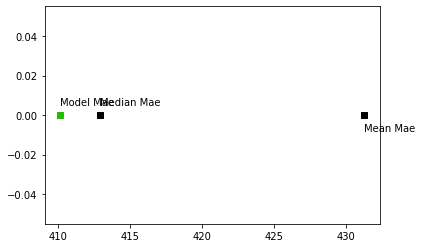

In [66]:
by = 0
ly = by + 0.005
pyplot.scatter(mean_mae, by, marker='s', c='#000000')
pyplot.annotate("Mean Mae", (mean_mae, ly - 0.013))
pyplot.scatter(median_mae, by, marker='s', c='#000000')
pyplot.annotate("Median Mae", (median_mae, ly))
if model_mae < mean_mae and model_mae < median_mae:
  mpcolor = '#27ba02'
elif model_mae <= mean_mae and model_mae >= median_mae:
  mpcolor = '#e7eb00'
elif model_mae > mean_mae and model_mae > median_mae:
  mpcolor = '#eb1000'
pyplot.scatter(model_mae, by, marker='s', c=mpcolor)
pyplot.annotate("Model Mae", (model_mae, ly))
pyplot.show()

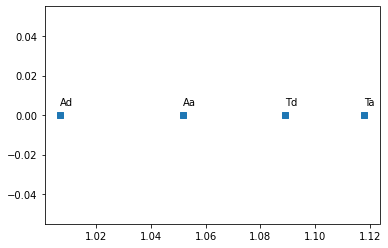

In [67]:
ta = 1.118
td = 1.089
base_y = 0
leg_y = base_y + 0.005
fa = mean_mae/model_mae
fd = median_mae/model_mae
pyplot.scatter([fa, fd, ta, td], np.full(4, base_y), marker='s')
pyplot.annotate("Aa", (fa, leg_y))
pyplot.annotate("Ad", (fd, leg_y))
pyplot.annotate("Ta", (ta, leg_y))
pyplot.annotate("Td", (td, leg_y))
pyplot.show()

# Células que ainda podem ser úteis

In [68]:
# Abrindo dados como ndarray
# data = []
# path = './drive/MyDrive/ColabNotebooks/data/'
# filelist = os.listdir(path)
# filelist.sort()
# # filelist = ['EVL_lab_clean.json']
# repo_num = len(filelist)
# print("Numero de repositorios: {}".format(repo_num))
# for filename in filelist:
#   with open(path + filename, 'r') as file:
#     repo = json.load(file)
#     data += repo
# ndata = pd.DataFrame(data).values
# pd_data = pd.DataFrame(data)
# if debug:
#   print(ndata)
#   print(ndata.shape)

In [69]:
# Arquivos das embeddings pré-treinadas
# emb_file = dict()
# emb_file[50] = './drive/MyDrive/ColabNotebooks/glove.6B.50d.txt'
# emb_file[100] = './drive/MyDrive/ColabNotebooks/glove.6B.100d.txt'
# emb_file[200] = './drive/MyDrive/ColabNotebooks/glove.6B.200d.txt'
# emb_file[300] = './drive/MyDrive/ColabNotebooks/glove.6B.300d.txt'

In [70]:
# bool_series = dvc[data["timespent"]] >= minimum_number_of_records
# data = data[bool_series.values]

In [71]:
# # Treinando com kfolds
# from keras.backend import clear_session
# clear_session()

# from sklearn.model_selection import KFold

# kf = KFold(n_splits=3)
# foldn = 1
# acc_hist = []
# acc_val_hist = []
# models = []
# for train_index, val_index in kf.split(x_train):
 
#   x_train_new = x_train[train_index]
#   y_train_new = y_train[train_index]

#   x_val = x_train[val_index]
#   y_val = y_train[val_index]

#   print("Fold {} ".format(foldn))
#   foldn += 1

#   model = compile_model(print_summary=False)
#   history = model.fit(x_train_new, y_train_new, epochs=10, batch_size=256, validation_data=(x_val, y_val), verbose=1)

#   models.append(model)
#   pyplot.plot(history.history['mae'])
#   pyplot.plot(history.history['val_mae'])
#   pyplot.title('model mae')
#   pyplot.ylabel('mae')
#   pyplot.xlabel('epoch')
#   pyplot.legend(['train', 'test'], loc='upper left')
#   pyplot.show()

In [72]:
# import seaborn as sns
# import matplotlib.pyplot as plt    
# from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(y_test, pred_class) 

# ax = plt.subplot()
# sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# # labels, title and ticks
# ax.set_xlabel('Predicted labels')
# ax.set_ylabel('True labels') 
# ax.set_title('Confusion Matrix') 
# ax.xaxis.set_ticklabels(categories) 
# ax.yaxis.set_ticklabels(categories)

In [73]:
# dvc = data['timespent'].value_counts()
# dvcs = dvc.sort_index()
# dvcs.index.to_numpy().astype(str)

# pyplot.figure(figsize=(10,10))
# pyplot.bar(dvcs.index.to_numpy().astype(str), dvcs.values)
# pyplot.show()

In [74]:
# Avaliando os modelos
# for i, model in enumerate(models):
#   print("MODELO {}".format(i))
#   print('Treino')
#   loss, metric = model.evaluate(x_train, y_train)
#   print('Loss: {}'.format(loss))
#   print('Metric: {}'.format(metric))
#   print('Test')
#   loss, metric = model.evaluate(x_test, y_test)
#   print('Loss: {}'.format(loss))
#   print('Metric: {}'.format(metric))

In [75]:
# Old figure of confusion matrix
# fig = pyplot.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(cm)
# pyplot.title('Confusion matrix of the classifier')
# fig.colorbar(cax)
# ax.set_xticklabels([''] + labels)
# ax.set_yticklabels([''] + labels)
# pyplot.xlabel('Predicted')
# pyplot.ylabel('True')
# pyplot.show()

In [76]:
# pyplot.plot(history.history['mae'])
# pyplot.plot(history.history['val_mae'])
# pyplot.title('model accuracy')
# pyplot.ylabel('mae')
# pyplot.xlabel('epoch')
# pyplot.legend(['train', 'test'], loc='upper left')
# pyplot.show()

In [77]:
# # Primeiro Quartil
# Q1 = pd_data['timespent'].quantile(0.25)
# print("Q1: {}".format(Q1))
# # Segundo Quartil
# Q2 = pd_data['timespent'].quantile(0.50)
# print("Q2: {}".format(Q2))
# # Terceiro Quartil
# Q3 = pd_data['timespent'].quantile(0.75)
# print("Q3: {}".format(Q3))
# # Amplitude Interquartil
# IQR = Q3 - Q1
# print("IQR: {}".format(IQR))
# # Limite Superior
# LI = Q1 - (1.5 * IQR)
# print("LI: {}".format(LI))
# # Limite Inferior
# LS = Q3 + (1.5 * IQR)
# print("LS: {}".format(LS))

In [78]:
# df_sem_outlier = pd.DataFrame(
#     pd_data[(
#         (pd_data['timespent'] >= LI) 
#         & (pd_data['timespent'] <= LS)
#     )])

# sns.boxplot(df_sem_outlier['timespent'])

In [79]:
# for pred in predictions:
#     if pred != 1089.0886 and pred != 1089.0885:
#       print(pred)

In [80]:
# # Visualizando o word embedding
# X = emb_model[emb_model.wv.vocab]
# pca = PCA(n_components=2)
# result = pca.fit_transform(X)
# fig, ax = pyplot.subplots()
# ax.scatter(result[:, 0], result[:, 1])
# xlim1 = -0.200
# xlim2 = -0.125
# ylim1 = -0.02
# ylim2 = 0.02
# limits = False

# words = list(emb_model.wv.vocab)
# for i, word in enumerate(words):
#   x = result[i, 0]
#   y = result[i, 1]
#   if limits:
#     if x >= xlim1 and x <= xlim2 and y >= ylim1 and y <= ylim2: 
# 	    ax.annotate(word, xy=(x, y))
#   else:
#     ax.annotate(word, xy=(x, y))

# if limits:
#   ax.set_xlim(xlim1, xlim2)
#   ax.set_ylim(ylim1, ylim2)

In [81]:
# prepare tokenizer
# t = Tokenizer()
# t.fit_on_texts(summary_list)
# vocab_size = len(t.word_index) + 1
# print(vocab_size)

In [82]:
# integer encode the documents
# encoded_docs = t.texts_to_sequences(summary_list)
# print(encoded_docs)

In [83]:
# padded_docs = pad_sequences(encoded_docs, maxlen=max_summary_length, padding='post')
# print(padded_docs)

In [84]:
# ss = StandardScaler()
# sclWord = ss.fit(emb_model.wv.vectors)
# vectors_normalized = sclWord.transform(vocab_dict.values())

# vectors_list = []
# for word in emb_model.wv.vocab:
#   vectors_list.append(emb_model.wv.get_vector(word))

# print(type(emb_model.wv.vocab))
# embeddings_index = dict()
# for i, word in enumerate(list(emb_model.wv.vocab)[0:10]):
#   print(emb_model.wv.vectors[i])
#   print(vectors_list[i])
	#embeddings_index[word] = vectors_normalized[i]

In [85]:
# count = 0
# for cara in embedding_matrix:
#   if cara[0] == 0:
#     count+=1
# print(count)